<a href="https://colab.research.google.com/github/HurleyJames/NNs/blob/master/Image_Caption_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Caption Generation

Starter code.



## Text preparation 

We need to build a vocabulary.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Mounted Drive if using Colab; otherwise, your local path
root = "drive/My Drive/Flickr8k/" # <--- replace this with your root data directory
caption_dir = root + "captions/"                       # <--- replace these too
image_dir = root + "images/"                           # <---


token_file = "Flickr8k.token.txt"

A helper function to read in our ground truth text file.

In [0]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:

In [0]:
lines = read_lines(caption_dir + token_file)

In [5]:
len(lines)

40455

In [0]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


splitting the image ID from the caption text and split the caption text into words and trim any trailing whitespaces

In [0]:
import re
import string

image_ids = []
captions = []

for i in lines:
    image_ids.append(i.split('\t')[0][:-6])
    i = i.split('\t')[1].replace(" .", ".").lower()
    i = re.sub("[{}]+".format(string.punctuation), "", i)
    captions.append(i.split())

In [0]:
total = sum(captions, [])

In [9]:
len(total)

436505

In [0]:
from collections import Counter

word = []
# c = Counter((map(tuple, captions)))
c = Counter(total)
# print(len(list(c.keys())))
# print(len(list(c.values())))
# print(len(c))
# print(list(c.keys())[1])
for j in range(len(c)):
    if (list(c.values())[j] > 3):
        word.append(list(c.keys())[j])

In [11]:
len(word)

3436

Build the vocabulary.

In [0]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

Add the rest of the words from the parsed captions:

``` vocab.add_word('new_word')```

Don't add words that appear three times or less.

In [0]:
for i in word:
    vocab.add_word(i)

In [14]:
len(vocab)

3440

## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

In [0]:
cleaned_captions = []

for i in range(len(captions)):
    cleaned_captions.append(" ".join(captions[i]))

The dataframe for the image paths and captions.

In [0]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [17]:
data_df.head(n=5)

,image_id,path,caption
0,1000268201_693b08cb0e,drive/My Drive/Flickr8k/images/1000268201_693b...,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,drive/My Drive/Flickr8k/images/1000268201_693b...,a girl going into a wooden building
2,1000268201_693b08cb0e,drive/My Drive/Flickr8k/images/1000268201_693b...,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e,drive/My Drive/Flickr8k/images/1000268201_693b...,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,drive/My Drive/Flickr8k/images/1000268201_693b...,a little girl in a pink dress going into a woo...


In [18]:
data_df.loc[1, 'caption']

'a girl going into a wooden building'

In [19]:
cleaned_captions[1]

'a girl going into a wooden building'

This is the Flickr8k class for the dataset.

In [0]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset, DataLoader

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [0]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [0]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [0]:
unit_size = 5

train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [0]:
train_loader = DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
    collate_fn=caption_collate_fn
)

test_loader = DataLoader(
    dataset_test,
    batch_size=128,
    shuffle=False,
    collate_fn=caption_collate_fn
)

## Encoder and decoder models

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        with torch.no_grad():
            features = self.resnet(images)
        # print("resnet_out:", features.shape)
        features = features.view(features.size(0), -1)
        # features = features.reshape(features.size(0), -1)
        # print("reshape:", features.shape)
        features = self.linear(features)
        # print("linear:", features.shape)
        features = self.bn(features)

        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        # self.lstm / self.rnn
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # self.lstm = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 

        hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [26]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Set training parameters.

In [0]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 1

model_path= root + "models/"

Initialize the models and set the learning parameters.

In [28]:
import numpy as np

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


## Training the model

The loop to train the model. Feel free to put this in a function if you prefer.

In [0]:
import os
loss_lstm = []
loss_rnn = []

In [37]:
encoder.train()
decoder.train()

if not os.path.exists(model_path):
    os.makedirs(model_path)

# before training
torch.save(encoder.state_dict(), os.path.join(model_path, 'RNN-encoder-0.ckpt'))
torch.save(decoder.state_dict(), os.path.join(model_path, 'RNN-decoder-0.ckpt'))

# Train the models
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item())) 

        # If you want to save the model checkpoints - recommended once you have everything working
        # Make sure to save RNN and LSTM versions separately
        # if (i+1) % save_step == 0:
        #     torch.save(decoder.state_dict(), os.path.join(model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
        #     torch.save(encoder.state_dict(), os.path.join(model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))
    # loss_lstm.append(loss.item())    
    loss_rnn.append(loss.item())
    torch.save(decoder.state_dict(), os.path.join(model_path, 'RNN-decoder-{}.ckpt'.format(epoch+1)))
    torch.save(encoder.state_dict(), os.path.join(model_path, 'RNN-encoder-{}.ckpt'.format(epoch+1)))
print('Finished')

Epoch [0/5], Step [0/301], Loss: 8.1644
Epoch [0/5], Step [10/301], Loss: 5.5057
Epoch [0/5], Step [20/301], Loss: 4.9802
Epoch [0/5], Step [30/301], Loss: 4.8846
Epoch [0/5], Step [40/301], Loss: 4.2962
Epoch [0/5], Step [50/301], Loss: 4.2076
Epoch [0/5], Step [60/301], Loss: 3.8386
Epoch [0/5], Step [70/301], Loss: 3.8141
Epoch [0/5], Step [80/301], Loss: 3.8384
Epoch [0/5], Step [90/301], Loss: 3.6251
Epoch [0/5], Step [100/301], Loss: 3.5491
Epoch [0/5], Step [110/301], Loss: 3.6697
Epoch [0/5], Step [120/301], Loss: 3.4015
Epoch [0/5], Step [130/301], Loss: 3.5061
Epoch [0/5], Step [140/301], Loss: 3.4887
Epoch [0/5], Step [150/301], Loss: 3.4322
Epoch [0/5], Step [160/301], Loss: 3.2245
Epoch [0/5], Step [170/301], Loss: 3.2568
Epoch [0/5], Step [180/301], Loss: 3.3192
Epoch [0/5], Step [190/301], Loss: 3.2835
Epoch [0/5], Step [200/301], Loss: 3.3415
Epoch [0/5], Step [210/301], Loss: 3.2134
Epoch [0/5], Step [220/301], Loss: 3.2223
Epoch [0/5], Step [230/301], Loss: 3.1730
Epo

In [34]:
loss_lstm

[2.978743314743042,
 2.6428117752075195,
 2.5709972381591797,
 2.545107126235962,
 2.3226895332336426]

In [38]:
loss_rnn

[3.25370454788208,
 2.737464189529419,
 2.622144937515259,
 2.2923169136047363,
 2.351238489151001]

In [0]:
def plot_loss(lstm, rnn):
    x = np.arange(0, 5)

    plt.figure()
    plt.plot(x, lstm, "r", "-", linewidth=1)

    plt.plot(x, rnn, "b", ":", linewidth=1)

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss of LSTM and RNN")

In [0]:
plot_loss(loss_lstm, loss_rnn)

## Random Interface from dataset

In [0]:
import random

def getRandomImage(img_list):
    """Returns a random filename, choose among the files of the given path"""
    index = random.randrange(0, len(img_list))
    return img_list[index], index

def loadImage(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224])

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

In [0]:
import matplotlib.pyplot as plt

img_list = []
img_path = caption_dir + "Flickr_8k.testImages.txt"

with open(img_path, 'r') as f:
    for i in f:
        img_list.append(i.strip())

In [0]:
# choose two random images for evaluation
filename1, index1 = getRandomImage(img_list)
filename2, index2 = getRandomImage(img_list)
image1 = loadImage(image_dir + str(filename1), data_transform)
image2 = loadImage(image_dir + str(filename2), data_transform) 

In [0]:
image1_id = image_ids.index(filename1[:-4])
image2_id = image_ids.index(filename2[:-4])

Loading checkpoint and initializing encoder and decoder

In [0]:
epoch_checkpoint = ['0', '1', '2', '3', '4', '5']

## BLEU for evaluation

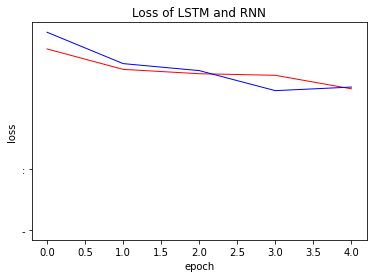

In [50]:
plot_loss(loss_lstm, loss_rnn)

In [0]:
from nltk.translate.bleu_score import corpus_bleu

def transform_idx_to_words(input):
    sampled_caption = []

    for idx in input:
        word = vocab.idx2word[idx]
        sampled_caption.append(word)

        if word == '<end>':
            break
    
    output = ' '.join(sampled_caption[1:-1])
    output = output.replace(' ,', ',')
    
    return output.split(' ')

In [37]:
len(test_loader.dataset)

2025

### LSTM Model

In [39]:
from nltk.translate.bleu_score import sentence_bleu

bleu_score1 = []
bleu_score2 = []
show1_captions = []
show2_captions = []

bleu_scores = []
long_scores = []
short_scores = []

for model_name in range(len(epoch_checkpoint)):
    print(model_name)
    encoder_model_path = os.path.join(model_path, 'LSTM-encoder-{}.ckpt'.format(model_name))
    decoder_model_path = os.path.join(model_path, 'LSTM-decoder-{}.ckpt'.format(model_name))

    test_encoder = EncoderCNN(embed_size)
    test_decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)    

    test_encoder.load_state_dict(torch.load(encoder_model_path))
    test_decoder.load_state_dict(torch.load(decoder_model_path))

    if torch.cuda.is_available():
        test_encoder = test_encoder.to(device)
        test_decoder = test_decoder.to(device)

    test_encoder.eval()
    test_decoder.eval()

    image1 = image1.to(device)
    image2 = image2.to(device)

    predicted, actual = list(), list()
    predicted_total, actual_total = list(), list()    

    for i in range(len(test_loader.dataset)):
        image, caption = test_loader.dataset.__getitem__(i)
        image = image.unsqueeze(0).to(device)
        features = test_encoder(image)
        caps = test_decoder.sample(features)
        caps = caps.cpu().data.numpy()[0,:]
        if i % 5 == 0:
            predicted_total.append(" ".join(transform_idx_to_words(caps[0:])))

        actual_total.append(caption.numpy())

    actual_total = [[transform_idx_to_words(item)] for item in actual_total]

    refer_total = [[] for _ in range(len(predicted_total))]

    for i in range(len(actual_total)):
        sentence = " ".join(actual_total[i][0])
        refer_total[i//5].append(sentence)

    bleu = corpus_bleu(refer_total, predicted_total, weights=(0.5, 0.5, 0, 0))

    # long and short captions
    long_captions = [[] for _ in range(len(refer_total))]
    short_captions = [[] for _ in range(len(refer_total))]
    for i in range(len(refer_total)):
        for j in range(5):
            if (refer_total[i][j].count(" ") + 1 > 12):
                long_captions[i].append(refer_total[i][j])
            else:
                short_captions[i].append(refer_total[i][j])

    exist1 = 0
    for i in range(len(long_captions)):
        if long_captions[i]:
            exist1 = exist1 + 1;
        else:
            long_captions[i] = ['']

    exist2 = 0
    for j in range(len(short_captions)):
        if short_captions[j]:
            exist2 = exist2 + 1;
        else:
            short_captions[j] = ['']

    bleu_long = corpus_bleu(long_captions, predicted_total, weights=(0.5, 0.5, 0, 0))
    bleu_short = corpus_bleu(short_captions, predicted_total, weights=(0.5, 0.5, 0, 0))

    feature1 = test_encoder(image1)
    cap1 = test_decoder.sample(feature1)
    cap1 = cap1.cpu().data.numpy()
    # cap1 = cap1[0,:]

    feature2 = test_encoder(image2)
    cap2 = test_decoder.sample(feature2)
    cap2 = cap2.cpu().data.numpy()
    # cap2 = cap2[0,:]
 
    predicted.append(cap1)
    predicted.append(cap2)

    predicted1 = " ".join(transform_idx_to_words(predicted[0][0,:]))
    predicted2 = " ".join(transform_idx_to_words(predicted[1][0,:]))

    print("The generated caption of 1st image: " + predicted1)

    hypotheses = list()
    references = list()
    refer = list()

    # 1st image
    hypotheses.append(predicted1)
    show1_captions.append(predicted1)
    for i in range(len(epoch_checkpoint) - 1):
        refer.append(cleaned_captions[image1_id + i])
    references.append(refer)

    bleu1 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))

    # 2nd image
    print("The generated caption of 2nd image: " + predicted2)

    hypotheses.clear()
    references.clear()
    refer.clear()

    hypotheses.append(predicted2)
    show2_captions.append(predicted2)
    for i in range(len(epoch_checkpoint) - 1):
        refer.append(cleaned_captions[image2_id + i])
    references.append(refer)

    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0)) 

    bleu_score1.append((model_name, bleu1))
    bleu_score2.append((model_name, bleu2))
    bleu_scores.append((model_name, bleu))
    long_scores.append((model_name, bleu_long))
    short_scores.append((model_name, bleu_short))
    print('done for model: {}'.format(model_name))

0
The generated caption of 1st image: watches bridal spout special speeding blue luggage jockeys guards shower fatigues redhaired litter friend writes dock crashes pole
The generated caption of 2nd image: collars infant melting tackles surfers abandoned enjoying placing pathway saxophone so bluejeans steer different squat keep ear serving
done for model: 0
1
The generated caption of 1st image: a man in a red shirt and a woman in a blue shirt and a woman in a
The generated caption of 2nd image: a man in a blue shirt is jumping over a skateboard
done for model: 1
2
The generated caption of 1st image: a group of people are sitting in a <unk>
The generated caption of 2nd image: a man in a yellow shirt is standing on a beach
done for model: 2
3
The generated caption of 1st image: a group of people are standing in front of a building
The generated caption of 2nd image: a man is standing on a rock overlooking a lake
done for model: 3
4
The generated caption of 1st image: a group of people are

In [40]:
len(refer_total)

405

In [41]:
len(predicted_total)

405

In [42]:
show1_captions

['watches bridal spout special speeding blue luggage jockeys guards shower fatigues redhaired litter friend writes dock crashes pole',
 'a man in a red shirt and a woman in a blue shirt and a woman in a',
 'a group of people are sitting in a <unk>',
 'a group of people are standing in front of a building',
 'a group of people are standing in front of a large crowd',
 'a group of people in a <unk> <unk>']

In [43]:
print("The information of 1st image:" + filename1 + "     " + str(image1_id))
for i in range(len(epoch_checkpoint) - 1):
    print('The {} reference caption of 1st image: '.format(i) + cleaned_captions[image1_id + i])

The information of 1st image:3364861247_d590fa170d.jpg     26455
The 0 reference caption of 1st image: a group of girls and guys hang out one is making a sad face
The 1 reference caption of 1st image: a group of women one serious one frowning and another smiling
The 2 reference caption of 1st image: a woman in a pink sweater looks pensive next to a crowd of laughing women
The 3 reference caption of 1st image: a young girl gazes at something in the distance as those around her talk
The 4 reference caption of 1st image: there are oriental people standing together


In [44]:
print("The information of 2nd image:" + filename2 + "     " + str(image2_id))
for i in range(len(epoch_checkpoint) - 1):
    print('The {} reference caption of 2nd image: '.format(i) + cleaned_captions[image2_id + i])

The information of 2nd image:968081289_cdba83ce2e.jpg     40315
The 0 reference caption of 2nd image: a boy jumping off of a dock while his friend watches
The 1 reference caption of 2nd image: two boys are climbing a wooden platform and jumping into a river
The 2 reference caption of 2nd image: two boys jumping off the pier into the water
The 3 reference caption of 2nd image: two boys preparing to jump off a pier located on a large body of water
The 4 reference caption of 2nd image: two children jump off the dock into the lake


In [45]:
bleu_score1

[(0, 0.537113911202859),
 (1, 0.6445033866354897),
 (2, 0.8207737278430061),
 (3, 0.8068378053269023),
 (4, 0.8791881034737313),
 (5, 0.6168964496271019)]

In [46]:
bleu_score2

[(0, 0.4664533983182601),
 (1, 0.7242104650034329),
 (2, 0.659380473395787),
 (3, 0.8209220690651828),
 (4, 0.7182499273587325),
 (5, 0.6900722090315506)]

In [47]:
bleu_scores

[(0, 0.4713130821602476),
 (1, 0.7610503115866862),
 (2, 0.7633911311569754),
 (3, 0.7931444917361669),
 (4, 0.8116659763495573),
 (5, 0.7890949240573993)]

In [48]:
long_scores

[(0, 0.3356590233667031),
 (1, 0.4784959263946148),
 (2, 0.47166849346781003),
 (3, 0.475067747221403),
 (4, 0.5127730000443503),
 (5, 0.48156809283125623)]

In [49]:
short_scores

[(0, 0.35353718246303545),
 (1, 0.6420079565699623),
 (2, 0.6659925387834466),
 (3, 0.7095379324855604),
 (4, 0.698894586362009),
 (5, 0.6922753207828949)]

In [51]:
data_df.loc[image1_id, 'path']

'drive/My Drive/Flickr8k/images/3364861247_d590fa170d.jpg'

In [50]:
long = 0
short = 0
for i in range(len(refer_total)):
    for j in range(5):
        if (refer_total[i][j].count(" ") + 1 > 12):
            long = long + 1;
        else:
            short = short + 1;
print(long)
print(short)

611
1414


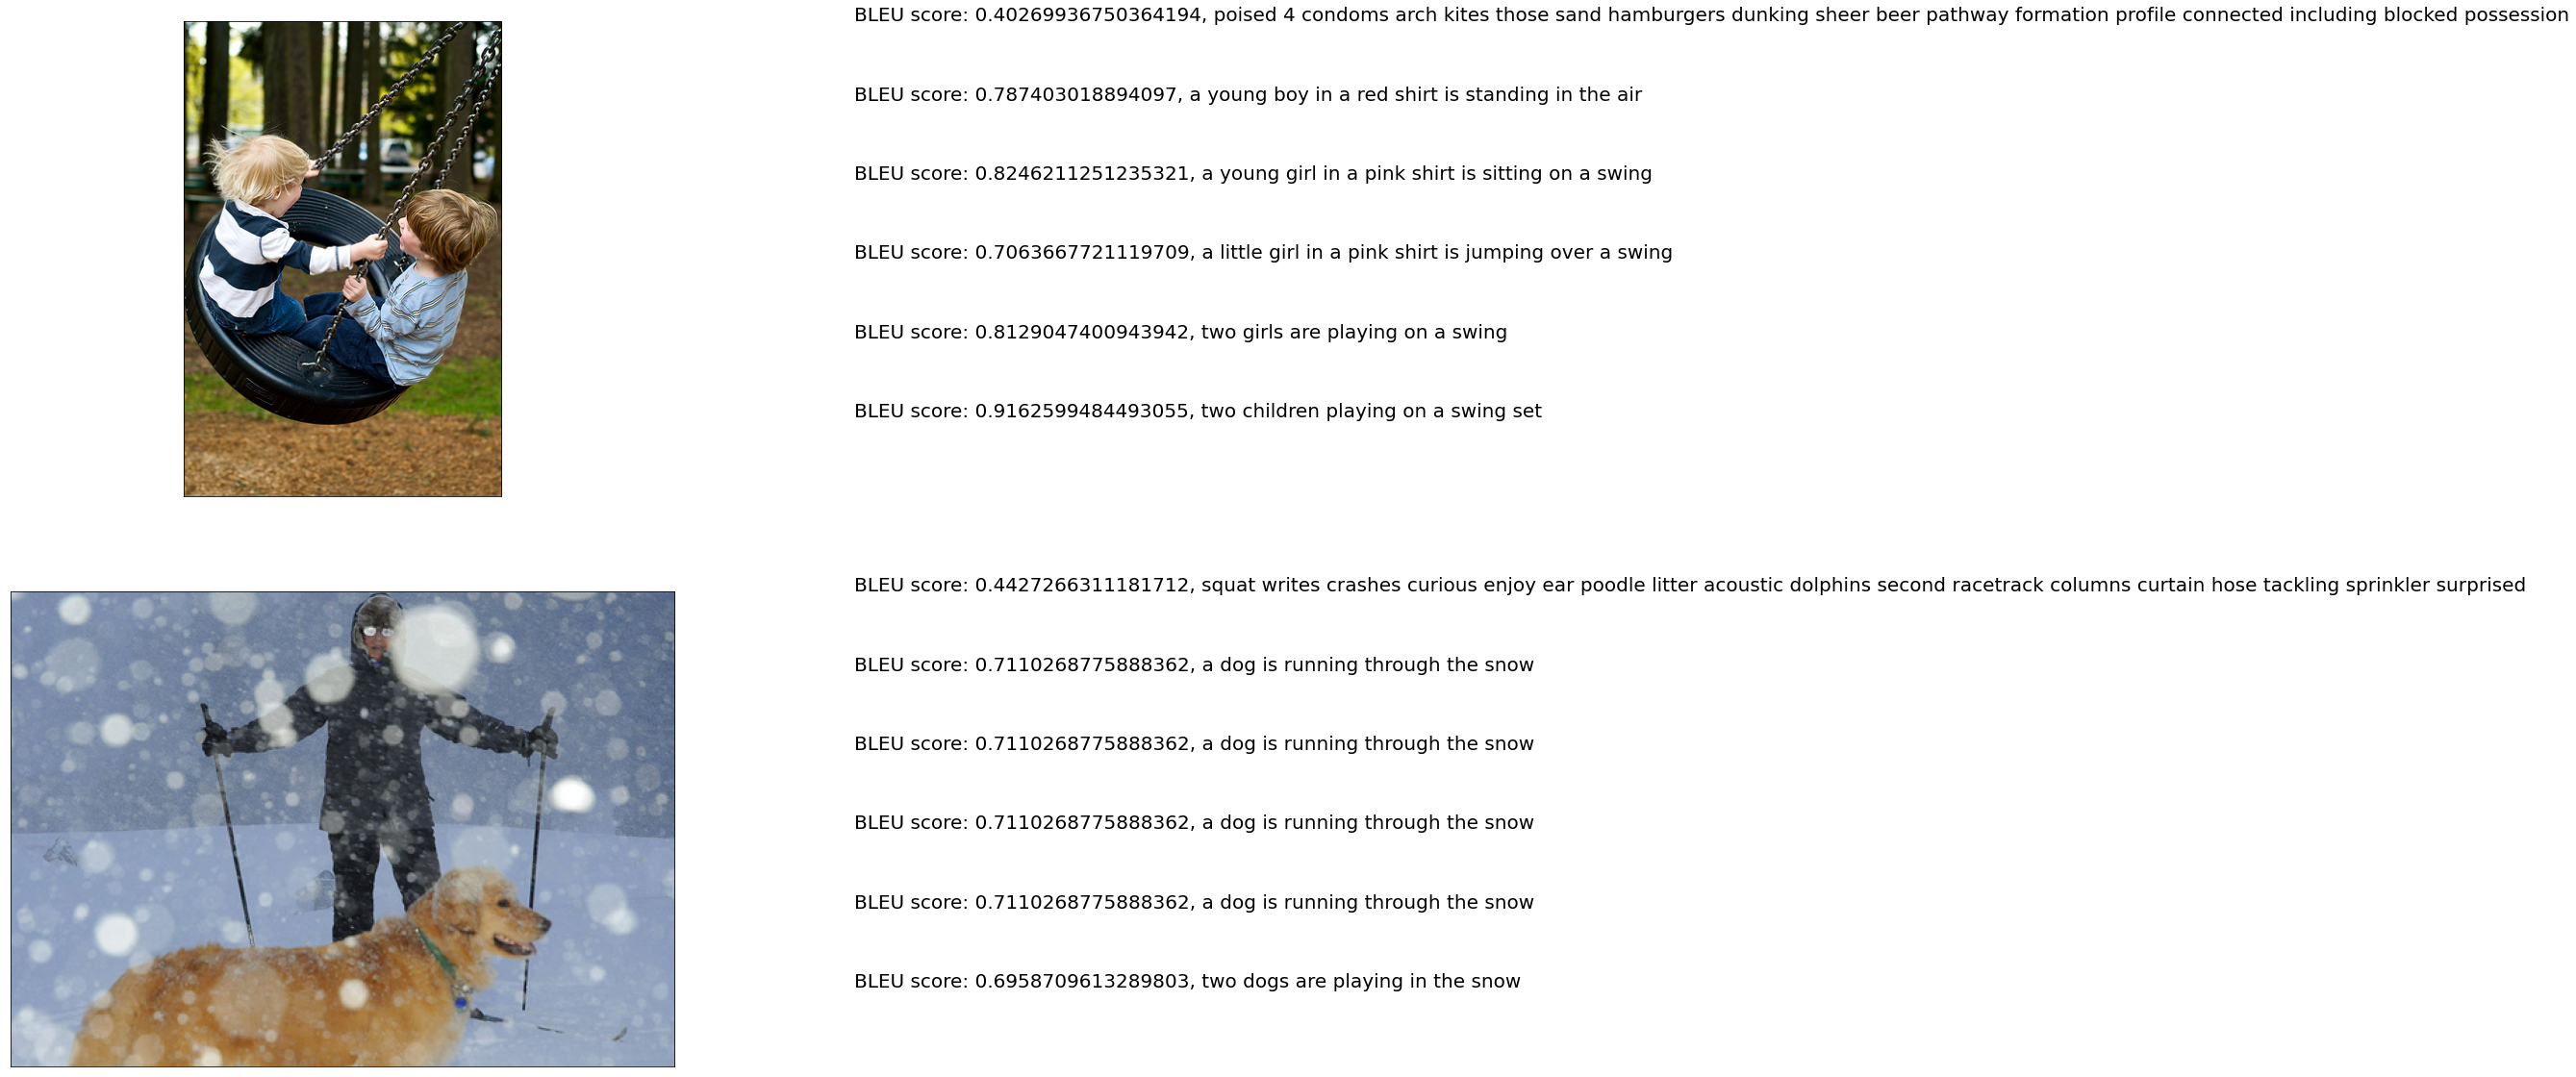

In [92]:
import matplotlib.image as img

npic = 2

count = 1
fig = plt.figure(figsize=(30,20))

pic1 = img.imread(data_df.loc[image1_id, 'path'])
pic2 = img.imread(data_df.loc[image2_id, 'path'])

for j in range(2):
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    if j == 0:
        ax.imshow(pic1)
        show_captions = show1_captions
    else:
        ax.imshow(pic2)
        show_captions = show2_captions
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(len(show_captions), 0)
    for i, caption in enumerate(show_captions):
        if j == 0:
            ax.text(0,i,'BLEU score: ' + str(bleu_score1[i][1]) + ', ' + caption,fontsize=20)
        else:
            ax.text(0,i,'BLEU score: ' + str(bleu_score2[i][1]) + ', ' + caption,fontsize=20)

    count += 1  
plt.show()

### RNN Model

In [0]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        with torch.no_grad():
            features = self.resnet(images)
        # print("resnet_out:", features.shape)
        features = features.view(features.size(0), -1)
        # features = features.reshape(features.size(0), -1)
        # print("reshape:", features.shape)
        features = self.linear(features)
        # print("linear:", features.shape)
        features = self.bn(features)

        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        # self.lstm / self.rnn
        self.lstm = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 

        hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [53]:
bleu_score1 = []
bleu_score2 = []
show1_captions = []
show2_captions = []

bleu_scores = []
long_scores = []
short_scores = []

for model_name in range(len(epoch_checkpoint)):
    print(model_name)
    encoder_model_path = os.path.join(model_path, 'RNN-encoder-{}.ckpt'.format(model_name))
    decoder_model_path = os.path.join(model_path, 'RNN-decoder-{}.ckpt'.format(model_name))

    test_encoder = EncoderCNN(embed_size)
    test_decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)    

    test_encoder.load_state_dict(torch.load(encoder_model_path))
    test_decoder.load_state_dict(torch.load(decoder_model_path))

    if torch.cuda.is_available():
        test_encoder = test_encoder.to(device)
        test_decoder = test_decoder.to(device)

    test_encoder.eval()
    test_decoder.eval()

    image1 = image1.to(device)
    image2 = image2.to(device)

    predicted, actual = list(), list()
    predicted_total, actual_total = list(), list()    

    for i in range(len(test_loader.dataset)):
        image, caption = test_loader.dataset.__getitem__(i)
        image = image.unsqueeze(0).to(device)
        features = test_encoder(image)
        caps = test_decoder.sample(features)
        caps = caps.cpu().data.numpy()[0,:]
        if i % 5 == 0:
            predicted_total.append(" ".join(transform_idx_to_words(caps[0:])))

        actual_total.append(caption.numpy())

    actual_total = [[transform_idx_to_words(item)] for item in actual_total]

    refer_total = [[] for _ in range(len(predicted_total))]

    for i in range(len(actual_total)):
        sentence = " ".join(actual_total[i][0])
        refer_total[i//5].append(sentence)

    bleu = corpus_bleu(refer_total, predicted_total, weights=(0.5, 0.5, 0, 0))

    # long and short captions
    long_captions = [[] for _ in range(len(refer_total))]
    short_captions = [[] for _ in range(len(refer_total))]
    for i in range(len(refer_total)):
        for j in range(5):
            if (refer_total[i][j].count(" ") + 1 > 12):
                long_captions[i].append(refer_total[i][j])
            else:
                short_captions[i].append(refer_total[i][j])

    exist1 = 0
    for i in range(len(long_captions)):
        if long_captions[i]:
            exist1 = exist1 + 1;
        else:
            long_captions[i] = ['']

    exist2 = 0
    for j in range(len(short_captions)):
        if short_captions[j]:
            exist2 = exist2 + 1;
        else:
            short_captions[j] = ['']

    bleu_long = corpus_bleu(long_captions, predicted_total, weights=(0.5, 0.5, 0, 0))
    bleu_short = corpus_bleu(short_captions, predicted_total, weights=(0.5, 0.5, 0, 0))

    feature1 = test_encoder(image1)
    cap1 = test_decoder.sample(feature1)
    cap1 = cap1.cpu().data.numpy()
    # cap1 = cap1[0,:]

    feature2 = test_encoder(image2)
    cap2 = test_decoder.sample(feature2)
    cap2 = cap2.cpu().data.numpy()
    # cap2 = cap2[0,:]
 
    predicted.append(cap1)
    predicted.append(cap2)

    predicted1 = " ".join(transform_idx_to_words(predicted[0][0,:]))
    predicted2 = " ".join(transform_idx_to_words(predicted[1][0,:]))

    print("The generated caption of 1st image: " + predicted1)

    hypotheses = list()
    references = list()
    refer = list()

    # 1st image
    hypotheses.append(predicted1)
    show1_captions.append(predicted1)
    for i in range(len(epoch_checkpoint) - 1):
        refer.append(cleaned_captions[image1_id + i])
    references.append(refer)

    bleu1 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))

    # 2nd image
    print("The generated caption of 2nd image: " + predicted2)

    hypotheses.clear()
    references.clear()
    refer.clear()

    hypotheses.append(predicted2)
    show2_captions.append(predicted2)
    for i in range(len(epoch_checkpoint) - 1):
        refer.append(cleaned_captions[image2_id + i])
    references.append(refer)

    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0)) 

    bleu_score1.append((model_name, bleu1))
    bleu_score2.append((model_name, bleu2))
    bleu_scores.append((model_name, bleu))
    long_scores.append((model_name, bleu_long))
    short_scores.append((model_name, bleu_short))
    print('done for model: {}'.format(model_name))

0
The generated caption of 1st image: outfits bread cheek elevation hula been shoe wall milk streamers shirts marketplace keeps ropes figure lunch chains tattoo
The generated caption of 2nd image: teenagers frozen husky wades suitcase approaching trucks glacier markings film chaps stand kayaks robot hear rocket bandaged coat
done for model: 0
1
The generated caption of 1st image: a man and a woman in a white shirt and a woman in a white shirt and a
The generated caption of 2nd image: a man in a blue shirt is standing on a bench
done for model: 1
2
The generated caption of 1st image: a group of people are sitting on a bench
The generated caption of 2nd image: a man in a black jacket is standing on a rock face
done for model: 2
3
The generated caption of 1st image: a group of people are standing in front of a <unk>
The generated caption of 2nd image: a man in a wetsuit is surfing
done for model: 3
4
The generated caption of 1st image: a woman in a red dress is smiling
The generated capti

In [54]:
show1_captions

['outfits bread cheek elevation hula been shoe wall milk streamers shirts marketplace keeps ropes figure lunch chains tattoo',
 'a man and a woman in a white shirt and a woman in a white shirt and a',
 'a group of people are sitting on a bench',
 'a group of people are standing in front of a <unk>',
 'a woman in a red dress is smiling',
 'a group of people are standing in front of a white house']

In [55]:
print("The information of 1st image:" + filename1 + "     " + str(image1_id))
for i in range(len(epoch_checkpoint) - 1):
    print('The {} reference caption of 1st image: '.format(i) + cleaned_captions[image1_id + i])

The information of 1st image:3364861247_d590fa170d.jpg     26455
The 0 reference caption of 1st image: a group of girls and guys hang out one is making a sad face
The 1 reference caption of 1st image: a group of women one serious one frowning and another smiling
The 2 reference caption of 1st image: a woman in a pink sweater looks pensive next to a crowd of laughing women
The 3 reference caption of 1st image: a young girl gazes at something in the distance as those around her talk
The 4 reference caption of 1st image: there are oriental people standing together


In [56]:
print("The information of 2nd image:" + filename2 + "     " + str(image2_id))
for i in range(len(epoch_checkpoint) - 1):
    print('The {} reference caption of 2nd image: '.format(i) + cleaned_captions[image2_id + i])

The information of 2nd image:968081289_cdba83ce2e.jpg     40315
The 0 reference caption of 2nd image: a boy jumping off of a dock while his friend watches
The 1 reference caption of 2nd image: two boys are climbing a wooden platform and jumping into a river
The 2 reference caption of 2nd image: two boys jumping off the pier into the water
The 3 reference caption of 2nd image: two boys preparing to jump off a pier located on a large body of water
The 4 reference caption of 2nd image: two children jump off the dock into the lake


In [57]:
bleu_score1

[(0, 0.5843091237927108),
 (1, 0.5969679927928422),
 (2, 0.8317913178399909),
 (3, 0.9089127840335353),
 (4, 0.6784260327945343),
 (5, 0.8962740737393522)]

In [58]:
bleu_score2

[(0, 0.4841854624165247),
 (1, 0.6988362419217079),
 (2, 0.6510606384765211),
 (3, 0.37658187515421365),
 (4, 0.8118441408859888),
 (5, 0.8118441408859888)]

In [59]:
bleu_scores

[(0, 0.48550844758033884),
 (1, 0.7472770086559569),
 (2, 0.7869210591195144),
 (3, 0.7848279622936846),
 (4, 0.7842382033701591),
 (5, 0.790244765474373)]

In [61]:
long_scores

[(0, 0.3459126734045718),
 (1, 0.4941326976269798),
 (2, 0.4629657919631479),
 (3, 0.4535074203818844),
 (4, 0.4578482300900847),
 (5, 0.5144687664066672)]

In [62]:
short_scores

[(0, 0.3640724491509698),
 (1, 0.6212773273185395),
 (2, 0.6941494588941823),
 (3, 0.6986415255067928),
 (4, 0.7082044065271984),
 (5, 0.6727872783925738)]

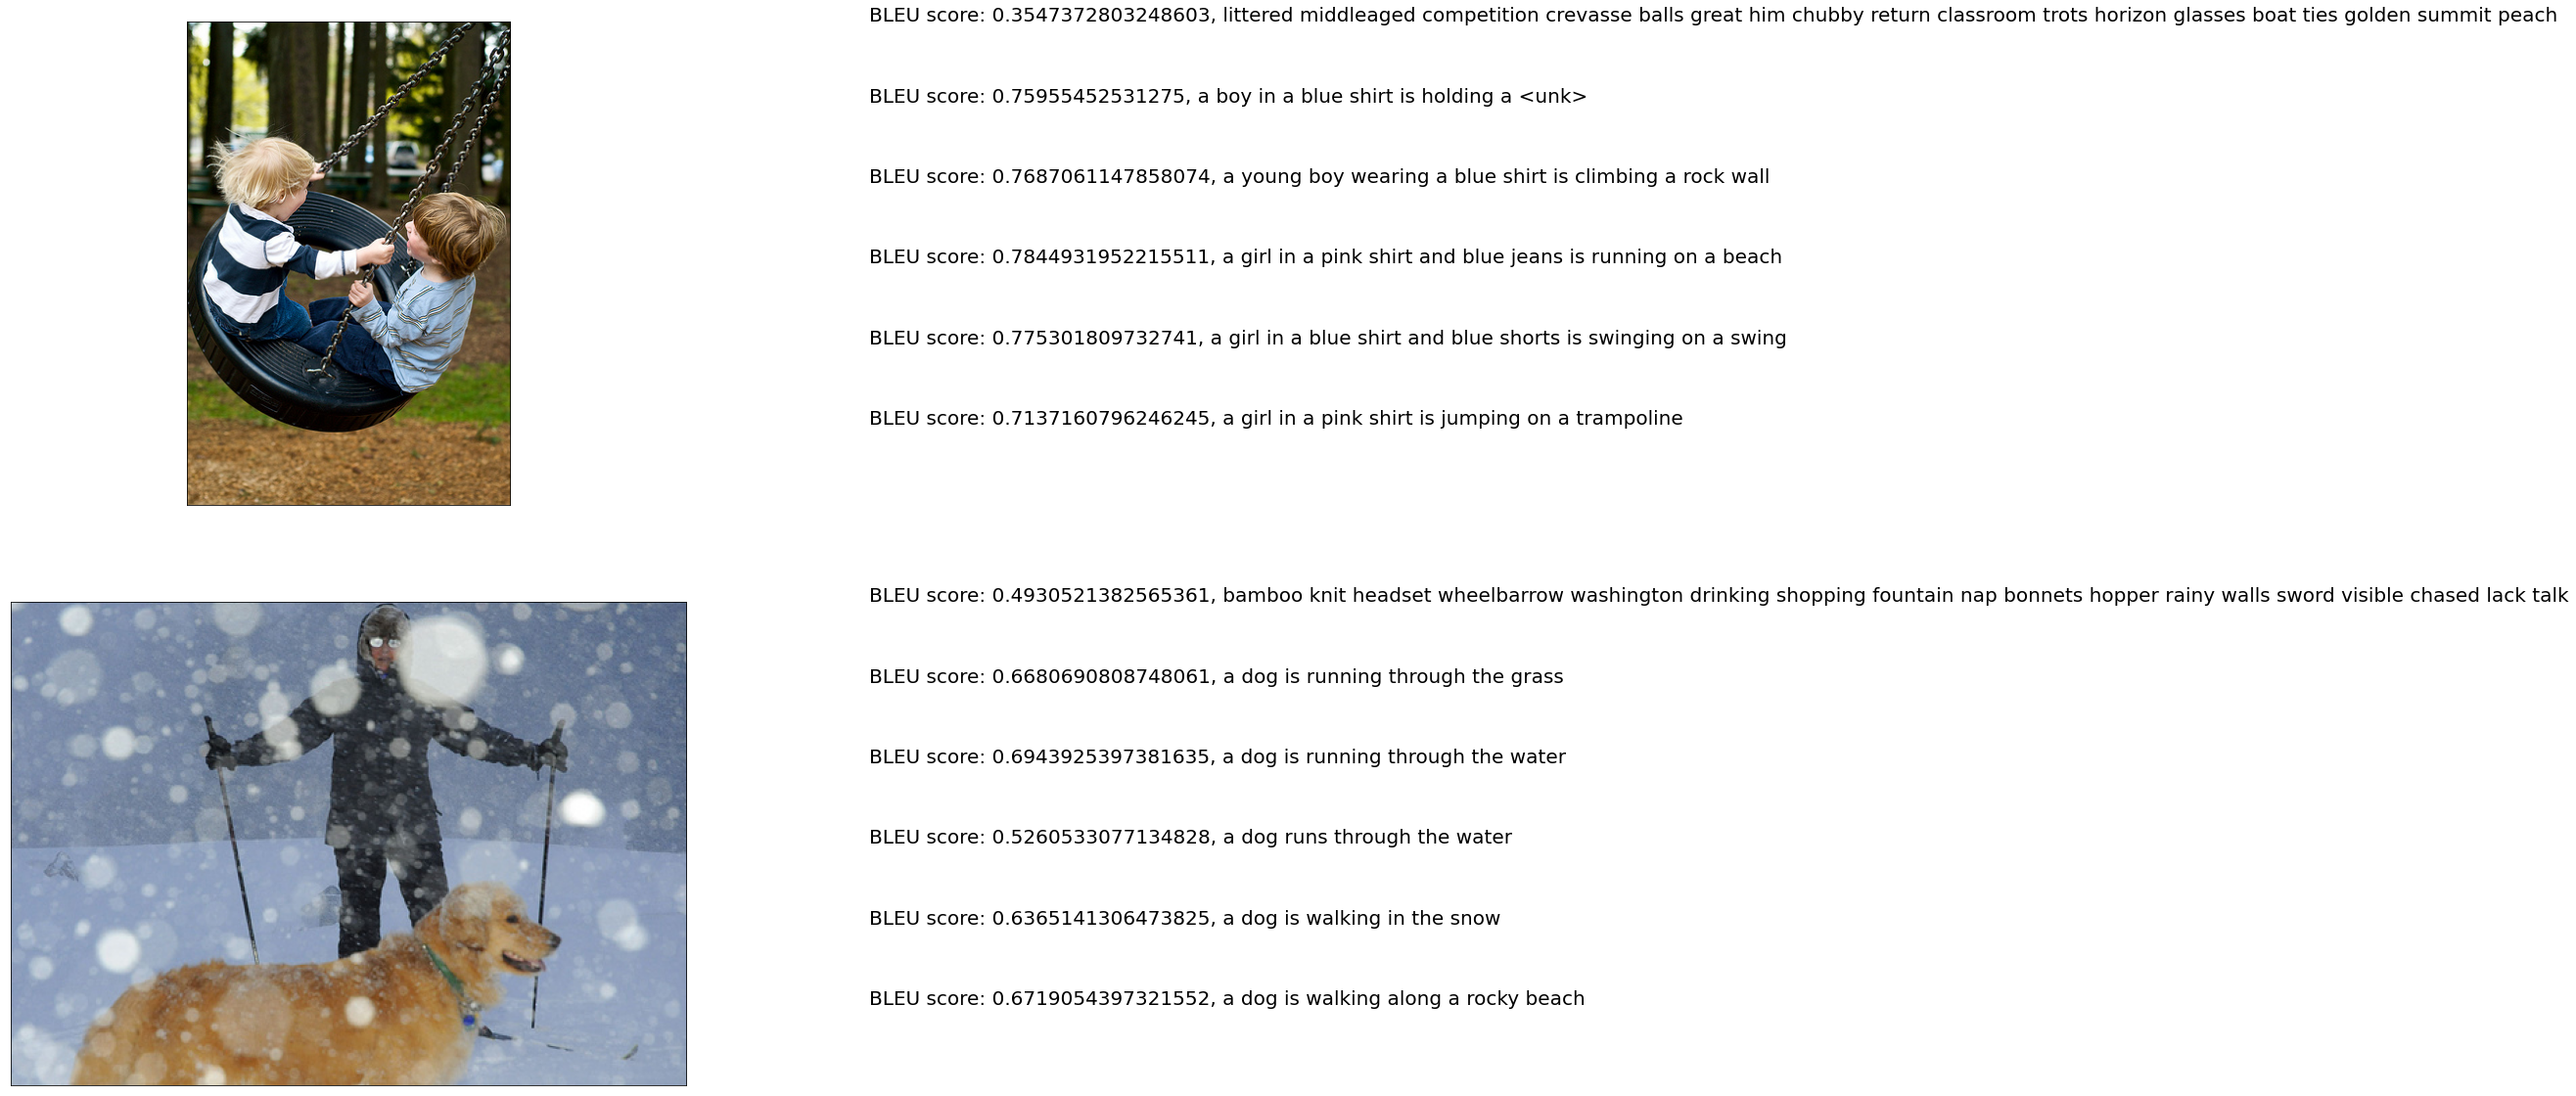

In [98]:
npic = 2

count = 1
fig = plt.figure(figsize=(30,20))

pic1 = img.imread(data_df.loc[image1_id, 'path'])
pic2 = img.imread(data_df.loc[image2_id, 'path'])

for j in range(2):
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    if j == 0:
        ax.imshow(pic1)
        show_captions = show1_captions
    else:
        ax.imshow(pic2)
        show_captions = show2_captions
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(len(show_captions), 0)
    for i, caption in enumerate(show_captions):
        if j == 0:
            ax.text(0,i,'BLEU score: ' + str(bleu_score1[i][1]) + ', ' + caption,fontsize=20)
        else:
            ax.text(0,i,'BLEU score: ' + str(bleu_score2[i][1]) + ', ' + caption,fontsize=20)

    count += 1  
plt.show()